<font color='lime'>

# Model training and parameter selection with Grid Search

</font> 

<font color='yellow'>

## K-nearest neighbors (KNN)

</font> 

<font color='orange'>

### Load the dataset

</font> 

In [1]:
import pandas as pd

file_path = 'data/spotify_songs_with_mood.csv'
spotify_data = pd.read_csv(file_path)

<font color='orange'>

### Separate to training and test subset

</font> 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Selecting the features and the target
features = spotify_data[['danceability', 'energy', 'valence', 'acousticness']]
target = spotify_data['mood']

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# Checking the shape of the training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20222, 4), (8667, 4), (20222,), (8667,))

<font color='orange'>

### Run algorithm

</font> 

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Defining the KNN classifier and the grid search parameters
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 31, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fitting the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31, 2),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

<font color='orange'>

### Save model

</font> 

In [4]:
import joblib

# Save the best KNN model from grid search
best_knn_model = grid_search.best_estimator_
model_path = 'model/songs_mood_knn_model.joblib'
joblib.dump(best_knn_model, model_path)

# Return the path for confirmation
model_path

'model/songs_mood_knn_model.joblib'

<font color='orange'>

### Testing subset usage

</font> 

In [5]:
from sklearn.metrics import accuracy_score

# Making predictions on the test set
y_pred = best_knn_model.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Return the accuracy as a percentage
accuracy_percentage

97.8308526595131

<font color='yellow'>

## Model estimation

</font> 

<font color='orange'>

### Visualization of predicted values

</font> 

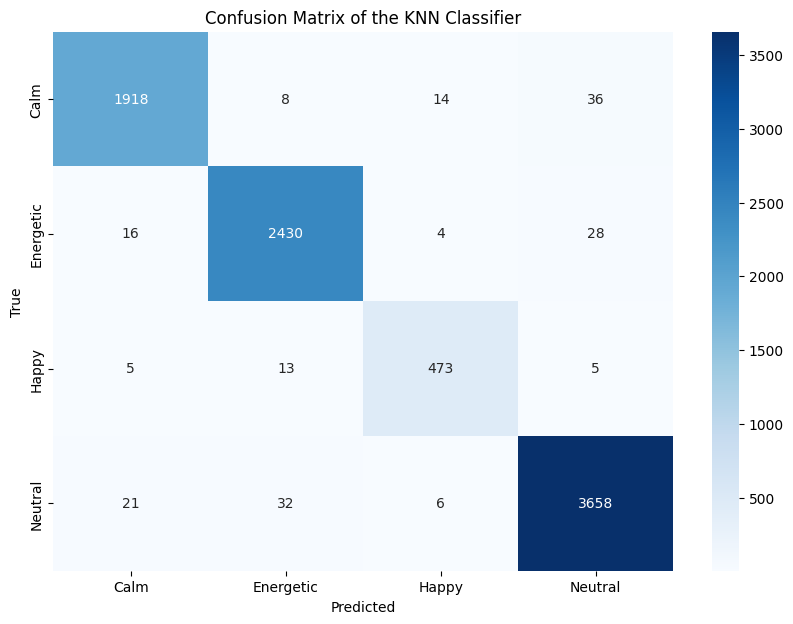

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_knn_model.classes_, yticklabels=best_knn_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of the KNN Classifier')
plt.show()

<font color='orange'>

### Prediction quality assessment (precision/recall/f1-score/ROC-AUC)

</font> 

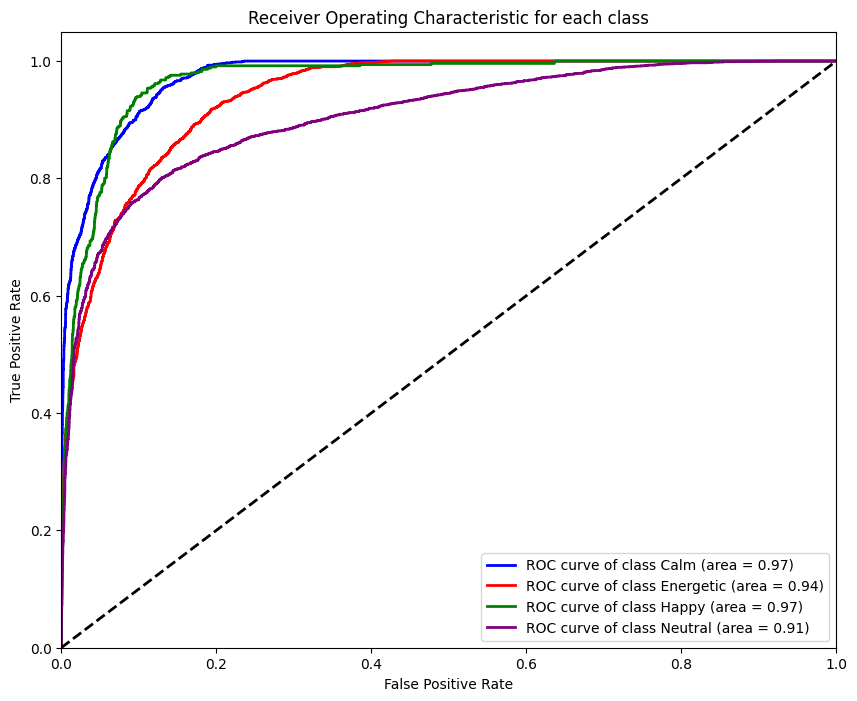

{0: 0.9739051399638284,
 1: 0.941907920415442,
 2: 0.9671268076320267,
 3: 0.9062019712867171}

In [9]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize the y_train and y_test for multi-class ROC AUC calculation
y_train_binarized = label_binarize(y_train, classes=np.unique(target))
y_test_binarized = label_binarize(y_test, classes=np.unique(target))

# Train a OneVsRestClassifier for Logistic Regression to compute ROC AUC
logreg_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
logreg_ovr.fit(X_train_scaled, y_train_binarized)

# Compute ROC AUC Score
roc_auc_ovr = dict()
fpr = dict()
tpr = dict()
thresholds = dict()

for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_binarized[:, i], logreg_ovr.predict_proba(X_test_scaled)[:, i])
    roc_auc_ovr[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = ['blue', 'red', 'green', 'purple']

for i, color in zip(range(y_test_binarized.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(np.unique(target)[i], roc_auc_ovr[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

roc_auc_ovr